# Previsão de Chuva - Classificação (Abordagem 2)

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import seaborn as sns

In [2]:
import sys
import os

# Adicionar src/ ao path do Python
sys.path.append(os.path.abspath('../src'))

# Agora o import funciona
from data_prep import prep_data

# 1 - Processamento de Dados

## 1.1 - Criação dos Dataframes
Função que faz todo o tratamento dos arquivos de entrada e gera dois Dataframes, um com os dados de entrada, e outro com os dados de saída.\
Código completo no arquivo `data_prep.py`

In [3]:
df_in, df_out = prep_data()

## 1.2 - Abordagem 1: Separação em Quadrimestres
Reorganizamos os dataframes em Quadrimestres em vez de Meses, agregando os dados.\
Nessa abordagem, usamos a média (`mean`) dos atributos de entrada, e a soma (`sum`) da precipitação total.

In [4]:
# Criar cópias dos dataframes originais para evitar modificações diretas
df_in_copy = df_in.copy()
df_out_copy = df_out.copy()

# Função para identificar o quadrimestre
def assign_quad(month):
    if month in [1, 2, 3, 4]:
        return 1
    elif month in [5, 6, 7, 8]:
        return 2
    elif month in [9, 10, 11, 12]:
        return 3

# Adicionar a coluna de quadrimestre
df_in_copy['QUAD'] = df_in_copy['MON'].apply(assign_quad)
df_out_copy['QUAD'] = df_out_copy['MON'].apply(assign_quad)

# Remover a coluna "MON" após criar "QUAD"
df_in_copy = df_in_copy.drop(columns=['MON'])
df_out_copy = df_out_copy.drop(columns=['MON'])  # Se aplicável

# Filtrar os dados de entrada e saída para incluir apenas anos de 1982 a 2023
df_in_copy = df_in_copy[(df_in_copy['YEAR'] >= 1982) & (df_in_copy['YEAR'] <= 2023)]
df_out_copy = df_out_copy[(df_out_copy['YEAR'] >= 1982) & (df_out_copy['YEAR'] <= 2023)]

# Função para calcular próximo quadrimestre
def proximo_quadrimestre(row):
    year = row['YEAR']
    quad = row['QUAD']
    if quad == 3:
        return pd.Series({'NEXT_YEAR': year + 1, 'NEXT_QUAD': 1})
    else:
        return pd.Series({'NEXT_YEAR': year, 'NEXT_QUAD': quad + 1})

# Adicionar colunas de próximo quadrimestre
df_in_copy[['NEXT_YEAR', 'NEXT_QUAD']] = df_in_copy.apply(proximo_quadrimestre, axis=1)

# Agregar dados de entrada (média) e saída (soma)
aggregated_in = df_in_copy.groupby(['YEAR', 'QUAD']).mean().reset_index()
aggregated_out = df_out_copy.groupby(['YEAR', 'QUAD'])['PRECIP'].sum().reset_index()

# Renomear colunas do target
aggregated_out_renamed = aggregated_out.rename(
    columns={'YEAR': 'NEXT_YEAR', 'QUAD': 'NEXT_QUAD', 'PRECIP': 'PRECIP_NEXT_QUAD'}
)

# Mesclar dados
aggregated_data = pd.merge(
    aggregated_in,
    aggregated_out_renamed,
    on=['NEXT_YEAR', 'NEXT_QUAD'],
    how='inner'
)

In [5]:
aggregated_data

,YEAR,QUAD,1_TW_CP,2_DarwinPr,3_TW_EP,4_TahitiPr,5_TW_WP,6_NATL,6_SATL,6_TROP,7_NINO1+2,7_NINO3,7_NINO4,7_NINO3.4,NEXT_YEAR,NEXT_QUAD,PRECIP_NEXT_QUAD
0,1982,1,8.000,7.725,10.025,12.150,0.650,25.4375,26.0300,27.8225,24.8625,26.6350,28.1975,27.0275,1982.0,2.0,991.126667
1,1982,2,6.275,13.750,9.425,12.600,-0.625,26.6275,23.6575,27.6200,22.6650,26.7475,29.0275,28.0125,1982.0,3.0,243.956667
2,1982,3,0.550,11.725,6.225,10.800,-2.125,26.8950,23.2125,27.5850,23.6775,27.2500,28.9200,28.4650,1983.0,1.0,609.933333
3,1983,1,0.975,10.075,3.700,8.700,1.350,25.7350,26.2875,28.2425,27.7275,28.5000,28.5550,28.5450,1983.0,2.0,659.611905
4,1983,2,6.750,13.375,6.325,14.450,3.425,26.8975,23.8275,27.8100,26.1225,27.2650,28.6025,27.5375,1983.0,3.0,244.042857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,2022,1,11.600,7.350,10.575,13.150,4.725,25.9875,26.9725,27.9750,24.6850,25.7400,27.8100,26.2350,2022.0,2.0,1282.361905
121,2022,2,10.975,11.850,9.850,15.125,6.625,27.3225,24.6975,27.6675,21.4825,25.6300,27.9650,26.6150,2022.0,3.0,311.586905
122,2022,3,11.375,8.700,10.450,14.250,4.975,27.8000,24.1250,27.3400,20.3325,24.2925,27.6875,25.8625,2023.0,1.0,547.216667
123,2023,1,11.050,7.200,9.900,12.125,3.725,26.0025,26.9050,28.1950,26.8425,26.7400,28.0250,26.8475,2023.0,2.0,937.335119


# 2 - Códigos de Preparação

## 2.1 - Definição das Classses

In [6]:
# Calcular a mediana da precipitação
median_precip = aggregated_data['PRECIP_NEXT_QUAD'].median()

# Criar uma função para classificar a precipitação
def classify_precipitation(precip):
    if precip <= median_precip:
        return 'Baixa Precipitação'
    else:
        return 'Alta Precipitação'

# Aplicar a função para criar a nova coluna de classe
aggregated_data['Precip_Class'] = aggregated_data['PRECIP_NEXT_QUAD'].apply(classify_precipitation)

# Converter rótulos para 0 e 1
label_mapping = {'Baixa Precipitação': 0, 'Alta Precipitação': 1}
aggregated_data['Precip_Class'] = aggregated_data['Precip_Class'].map(label_mapping)

# Exibir o dataframe resultante
aggregated_data

,YEAR,QUAD,1_TW_CP,2_DarwinPr,3_TW_EP,4_TahitiPr,5_TW_WP,6_NATL,6_SATL,6_TROP,7_NINO1+2,7_NINO3,7_NINO4,7_NINO3.4,NEXT_YEAR,NEXT_QUAD,PRECIP_NEXT_QUAD,Precip_Class
0,1982,1,8.000,7.725,10.025,12.150,0.650,25.4375,26.0300,27.8225,24.8625,26.6350,28.1975,27.0275,1982.0,2.0,991.126667,1
1,1982,2,6.275,13.750,9.425,12.600,-0.625,26.6275,23.6575,27.6200,22.6650,26.7475,29.0275,28.0125,1982.0,3.0,243.956667,0
2,1982,3,0.550,11.725,6.225,10.800,-2.125,26.8950,23.2125,27.5850,23.6775,27.2500,28.9200,28.4650,1983.0,1.0,609.933333,1
3,1983,1,0.975,10.075,3.700,8.700,1.350,25.7350,26.2875,28.2425,27.7275,28.5000,28.5550,28.5450,1983.0,2.0,659.611905,1
4,1983,2,6.750,13.375,6.325,14.450,3.425,26.8975,23.8275,27.8100,26.1225,27.2650,28.6025,27.5375,1983.0,3.0,244.042857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,2022,1,11.600,7.350,10.575,13.150,4.725,25.9875,26.9725,27.9750,24.6850,25.7400,27.8100,26.2350,2022.0,2.0,1282.361905,1
121,2022,2,10.975,11.850,9.850,15.125,6.625,27.3225,24.6975,27.6675,21.4825,25.6300,27.9650,26.6150,2022.0,3.0,311.586905,0
122,2022,3,11.375,8.700,10.450,14.250,4.975,27.8000,24.1250,27.3400,20.3325,24.2925,27.6875,25.8625,2023.0,1.0,547.216667,0
123,2023,1,11.050,7.200,9.900,12.125,3.725,26.0025,26.9050,28.1950,26.8425,26.7400,28.0250,26.8475,2023.0,2.0,937.335119,1


## 2.2 - Lista de Modelos

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

lista_modelos = [
    # =========================================================
    # 1. Random Forest
    # =========================================================
    {
        "nome_do_modelo": "Random Forest",
        "estimador": Pipeline([
            ('scaler', StandardScaler()), 
            ('pca', PCA()),
            ('classifier', RandomForestClassifier(random_state=42))
        ]),
        "parametros": {
            'pca__n_components': [2, 3, 4],          # Componentes do PCA
            'classifier__n_estimators': [50, 100],   # Número de árvores
            'classifier__max_depth': [None, 10, 20], # Profundidade máxima
            'classifier__min_samples_split': [2, 5]  # Divisão mínima
        }
    },

    # =========================================================
    # 2. Regressão Logística
    # =========================================================
    {
        "nome_do_modelo": "Logistic Regression",
        "estimador": Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "parametros": {
            'pca__n_components': [2, 3],             
            'classifier__C': [0.1, 1, 10],           # Regularização
            'classifier__penalty': ['l2', 'l1'],     
            'classifier__solver': ['liblinear']       # Solver compatível com L1/L2
        }
    },

    # =========================================================
    # 3. MLP (Multi-Layer Perceptron)
    # =========================================================
    {
        "nome_do_modelo": "MLP",
        "estimador": Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', MLPClassifier(random_state=42, early_stopping=True))
        ]),
        "parametros": {
            'pca__n_components': [3, 4],             
            'classifier__hidden_layer_sizes': [(50,), (100,)], # Camadas ocultas
            'classifier__activation': ['relu', 'tanh'], 
            'classifier__alpha': [0.0001, 0.001]     # Regularização L2
        }
    },

    # =========================================================
    # 4. KNN (K-Nearest Neighbors)
    # =========================================================
    {
        "nome_do_modelo": "KNN",
        "estimador": Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', KNeighborsClassifier())
        ]),
        "parametros": {
            'pca__n_components': [2, 3],             
            'classifier__n_neighbors': [3, 5, 7],    # Número de vizinhos
            'classifier__weights': ['uniform', 'distance'] 
        }
    },

    # =========================================================
    # 5. SVM (Support Vector Machine)
    # =========================================================
    {
        "nome_do_modelo": "SVM",
        "estimador": Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', SVC(random_state=42, probability=True)) # probability=True para ROC
        ]),
        "parametros": {
            'pca__n_components': [2, 3],             
            'classifier__C': [0.1, 1, 10],           # Penalidade de erro
            'classifier__kernel': ['rbf', 'linear'], 
            'classifier__gamma': ['scale', 'auto']   
        }
    }
]

# 3 - Treinamento




 **** RESULTADO DOS MODELOS + CURVAS ROC E PR ****

....nando modelo Random Forest .
-- coletando e armazenando resultados --

 - Acurácia   : 0.7920 +/- 0.10245
 - Precisão   : 0.7915 +/- 0.12364
 - Revocação  : 0.8077 +/- 0.12027
 - F1 - Score : 0.7934 +/- 0.09846
 - ROC - AUC  : 0.9154 +/- 0.07154
 - PR - AUC   : 0.9273 +/- 0.05891
 - Tempo médio de treinamento: 3.39 segundos


...inando modelo Logistic Regression ..
-- coletando e armazenando resultados --

 - Acurácia   : 0.8240 +/- 0.12027
 - Precisão   : 0.8461 +/- 0.14713
 - Revocação  : 0.8064 +/- 0.08411
 - F1 - Score : 0.8237 +/- 0.11348
 - ROC - AUC  : 0.9064 +/- 0.11196
 - PR - AUC   : 0.9329 +/- 0.06901
 - Tempo médio de treinamento: 0.11 segundos


....nando modelo MLP .
-- coletando e armazenando resultados --

 - Acurácia   : 0.7360 +/- 0.07419
 - Precisão   : 0.6848 +/- 0.09362
 - Revocação  : 0.9205 +/- 0.07179
 - F1 - Score : 0.7780 +/- 0.04973
 - ROC - AUC  : 0.9256 +/- 0.01840
 - PR - AUC   : 0.9328 +/- 0.02685

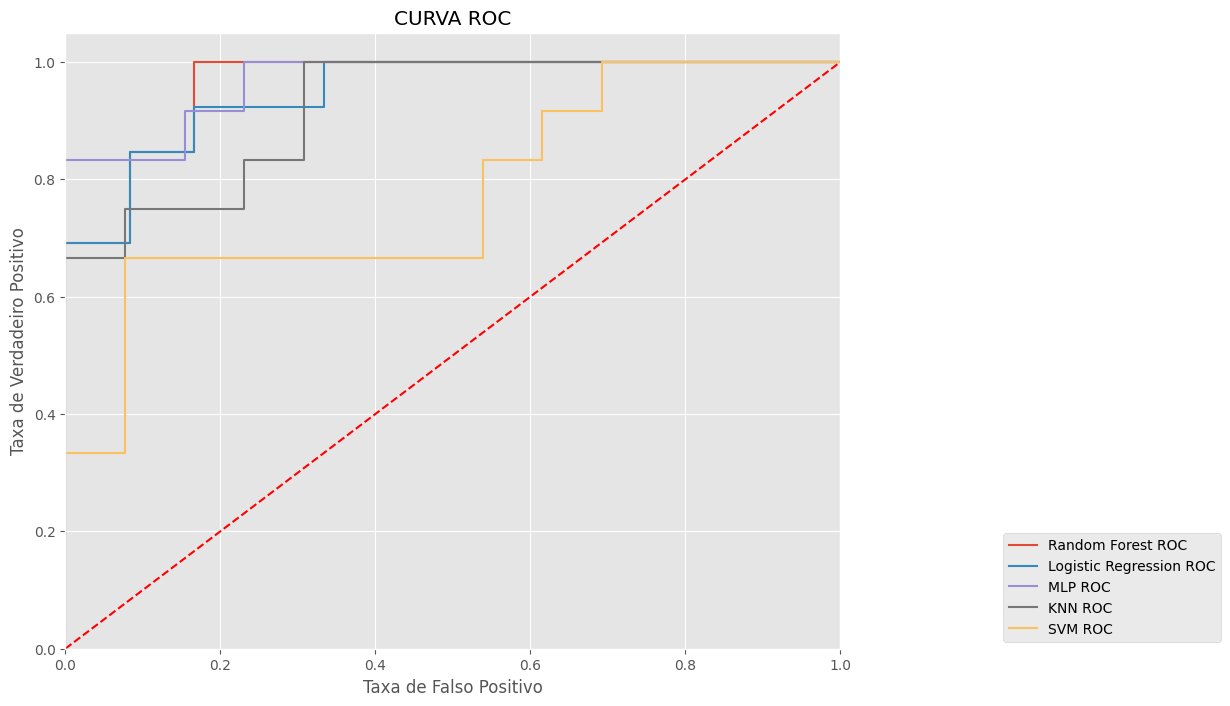

In [8]:
from classification_train_util import nested_cross_validation_grid_search

# Separar features e target (excluindo metadados temporais)
X = aggregated_data.drop(columns=[
    'Precip_Class', 'YEAR', 'QUAD', 'NEXT_YEAR', 'NEXT_QUAD', 'PRECIP_NEXT_QUAD'
])
y = aggregated_data['Precip_Class']

# Chamar a função de validação cruzada com os dados processados
resultados_gerais = nested_cross_validation_grid_search(
    lista_modelos=lista_modelos,
    X=X,
    y=y,
    k_folds_outer=5,
    k_folds_inner=3
)

# 4 - Resultados

In [9]:
# Converter os resultados para DataFrame
df_resultados = pd.DataFrame(resultados_gerais).T.reset_index()
df_resultados = df_resultados.rename(columns={'index': 'Modelo'})

# Selecionar colunas relevantes
colunas = ['Modelo', 'F1_score_mean', 'Acurácia_mean', 'aucROC_mean', 'aucPR_mean']
df_comparacao = df_resultados[colunas]

# Ordenar pelo F1-score (métrica principal)
df_comparacao = df_comparacao.sort_values('F1_score_mean', ascending=False)

print(df_comparacao)

                Modelo F1_score_mean Acurácia_mean aucROC_mean aucPR_mean
1  Logistic Regression      0.823715         0.824     0.90641   0.932883
4                  SVM       0.80476         0.808    0.880769   0.882537
3                  KNN      0.798997         0.808    0.891667   0.888872
0        Random Forest      0.793376         0.792    0.915385   0.927258
2                  MLP      0.777994         0.736    0.925641   0.932781


<Figure size 1000x600 with 0 Axes>

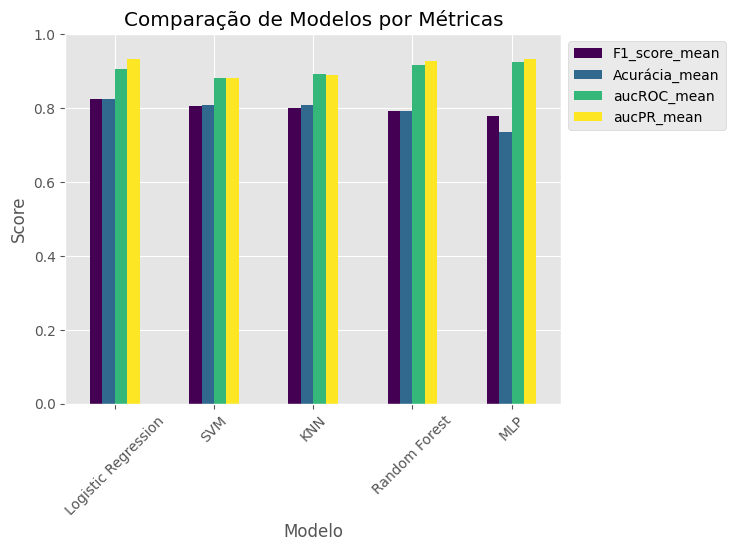

In [10]:
# Configurar o gráfico
plt.figure(figsize=(10, 6))
df_comparacao.set_index('Modelo').plot(kind='bar', rot=45, colormap='viridis')
plt.title('Comparação de Modelos por Métricas')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [11]:
# Pegar o melhor modelo com base no F1-score
melhor_modelo = df_comparacao.iloc[0]['Modelo']
melhor_f1 = df_comparacao.iloc[0]['F1_score_mean']
melhores_parametros = resultados_gerais[melhor_modelo]['melhores_parametros'][0]

# Imprimir em formato amigável
print(f"\n=== MELHOR MODELO ===")
print(f"Nome: {melhor_modelo}")
print(f"F1-Score Médio: {melhor_f1:.2f}")
print("\nParâmetros Otimizados:")
for parametro, valor in melhores_parametros.items():
    print(f" - {parametro}: {valor}")


=== MELHOR MODELO ===
Nome: Logistic Regression
F1-Score Médio: 0.82

Parâmetros Otimizados:
 - classifier__C: 1
 - classifier__penalty: l2
 - classifier__solver: liblinear
 - pca__n_components: 3
